# DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project

In this project, we'll use various unsupervised topic modeling techniques to uncover insights from customer reviews. The Amazon Reviews dataset on Kaggle will be used.

We'll experiment with three different techniques and compare their performance. The technques are the traditional Bag-of-Words based LDA algorithm, the more recent vector based BERTopic and the latest LLM based prompt completion.

## 1. Project Set Up

In [60]:
#!pip install bertopic
#!pip install openai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.4 MB/s eta 0:00:00


In [61]:
import string
from pprint import pprint

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import LdaModel
import gensim.corpora as corpora
import spacy
from bertopic import BERTopic
from openai import OpenAI

import pyLDAvis
import pyLDAvis.gensim

seed = 168

## 2. Exploratory Data Analysis

In [3]:
df = pd.read_csv('/kaggle/input/amazon-reviews/test.csv', header=None)
df.head()

,0,1,2
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       400000 non-null  int64 
 1   1       399976 non-null  object
 2   2       400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


The dataset is reasonably large and doesn't have missing values in the main analysis target feature ("review text"), although there are a small percentage of missing review titles. We can combine review title and review text to not only provide more information to the machine learnig model, but also compensate for the missing data in titles. 

In [5]:
# Tidy up the data
df.columns = ['class', 'review_title', 'review_text']
df.head()

,class,review_title,review_text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [6]:
def preprocess(df, frac=.01):
    # Sample the data
    df_new = df.sample(frac=frac)
    # Combine columns
    def concat_text(row):
        return f"[Review Title]: {row['review_title']}\n[Review Text]: {row['review_text']}"
    df_new['text'] = df_new.apply(lambda row: concat_text(row), axis=1)
    
    return df_new

In [7]:
df_new = preprocess(df)
df_new

,class,review_title,review_text,text
114233,2,its a shirt!!!,"really, what can be said? its a camouflage shi...",[Review Title]: its a shirt!!!\n[Review Text]:...
366249,1,Good only for one year,I have seen this problem with 2 Razor that we ...,[Review Title]: Good only for one year\n[Revie...
280831,1,TERRIBLE MODEL,THIS MODEL AIRCRAFT IS INCOMPLETE IT IS MISSIN...,[Review Title]: TERRIBLE MODEL\n[Review Text]:...
150396,1,this is not the metal band T.N.T - and this cd...,IF YOU THINK THIS IS THE KILLER METAL BAND OF ...,[Review Title]: this is not the metal band T.N...
368423,1,Hamilton dog collar .,Hamlton dog collar nice collar except plastic ...,[Review Title]: Hamilton dog collar .\n[Review...
...,...,...,...,...
311286,1,Fematril failure!,"i was very disappointed with this product , no...",[Review Title]: Fematril failure!\n[Review Tex...
50800,1,Does NOT fit ALL Hamilton Beach Blenders as ad...,Too small for my Wave-Action 10-speed. Frustra...,[Review Title]: Does NOT fit ALL Hamilton Beac...
174197,2,Your plot will thicken.,I agree with another reviewer that this book i...,[Review Title]: Your plot will thicken.\n[Revi...
348965,2,Someone knows how I feel!,"From my solitude a voice saying ""I understand!...",[Review Title]: Someone knows how I feel!\n[Re...


In [8]:
for i in df_new.text.sample(10).values.tolist():
    print(i, '\n')

[Review Title]: A bounteous trip to 1940s Italy
[Review Text]: I finished AKFM last night and I thoroughly enjoyed it. It was my incentive to get to bed early for several nights, and it kept me up too late each time! I want to go to Santa Cecilia and the olive grove and I want to eat some of Celestina's soup. Standing under chestnut trees has a whole new meaning for me now. Vito, Maddalena, Carolina, Buccio, Concetta--I can't get over how many characters the author developed and how the story remained true to their time and circumstances. Not just a love story, but a painless history lesson, a celebration of place, and an examination of the power of both passionate and familial love. The prose is cooked just right: al dente, with plenty of rich dialogue on top. This is a novel where you get your money's worth. 

[Review Title]: Gosh Darn This Release!
[Review Text]: Another record company swindle! Too bad this is the Gulf War version of the song and not the revised version that Greenwo

<Axes: ylabel='Frequency'>

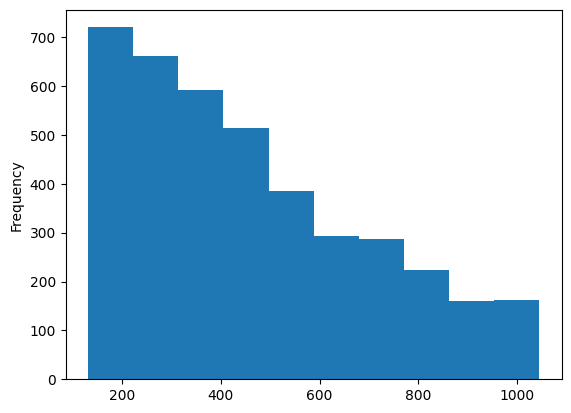

In [9]:
# Check text length distribution
df_new.text.apply(lambda x: len(x)).plot(kind='hist')

Texts with roughly 200 characters are the most numerous, followed by 300, 400, all the way to 1000 characters. Potentially, this can represent some challenge when working with LLM's due to limitation in context window size.


## 2. Traditional Topic Modeling Method: LDA

To use the LDA algorithm, we first need to tokenize and vectorize the text, then we'll try different number of topics and visualize the topics.

In [10]:
def tokenize(text):
    text = "".join([i for i in text if i not in string.punctuation])
    text = text.lower()
    tokens = word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [i for i in tokens if i not in stopwords]
    
    return tokens

df_new['text_normalized'] = df_new.text.apply(lambda x: tokenize(x))
df_new.head()

,class,review_title,review_text,text,text_normalized
114233,2,its a shirt!!!,"really, what can be said? its a camouflage shi...",[Review Title]: its a shirt!!!\n[Review Text]:...,"[review, title, shirt, review, text, really, s..."
366249,1,Good only for one year,I have seen this problem with 2 Razor that we ...,[Review Title]: Good only for one year\n[Revie...,"[review, title, good, one, year, review, text,..."
280831,1,TERRIBLE MODEL,THIS MODEL AIRCRAFT IS INCOMPLETE IT IS MISSIN...,[Review Title]: TERRIBLE MODEL\n[Review Text]:...,"[review, title, terrible, model, review, text,..."
150396,1,this is not the metal band T.N.T - and this cd...,IF YOU THINK THIS IS THE KILLER METAL BAND OF ...,[Review Title]: this is not the metal band T.N...,"[review, title, metal, band, tnt, cd, good, re..."
368423,1,Hamilton dog collar .,Hamlton dog collar nice collar except plastic ...,[Review Title]: Hamilton dog collar .\n[Review...,"[review, title, hamilton, dog, collar, review,..."


In [36]:
id2word = corpora.Dictionary(df_new.text_normalized.tolist())
corpus = [id2word.doc2bow(text) for text in df_new.text_normalized.tolist()]

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20,
    random_state=seed,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [37]:
pprint(lda_model.print_topics())

[(0,
  '0.070*"works" + 0.045*"may" + 0.034*"power" + 0.030*"products" + 0.025*"20" '
  '+ 0.024*"huge" + 0.023*"black" + 0.020*"computer" + 0.019*"opinion" + '
  '0.018*"older"'),
 (1,
  '0.015*"creative" + 0.010*"weekly" + 0.008*"adding" + 0.005*"numbers" + '
  '0.003*"enjoys" + 0.000*"job" + 0.000*"player" + 0.000*"finally" + '
  '0.000*"favorite" + 0.000*"bratz"'),
 (2,
  '0.049*"need" + 0.038*"away" + 0.029*"set" + 0.028*"movies" + 0.028*"feel" + '
  '0.027*"wasnt" + 0.025*"terrible" + 0.025*"started" + 0.023*"horrible" + '
  '0.022*"working"'),
 (3,
  '0.020*"effective" + 0.008*"shorter" + 0.005*"writings" + 0.000*"fleas" + '
  '0.000*"mouse" + 0.000*"vet" + 0.000*"august" + 0.000*"frontline" + '
  '0.000*"harder" + 0.000*"group"'),
 (4,
  '0.051*"show" + 0.033*"takes" + 0.028*"tv" + 0.027*"stand" + 0.023*"girl" + '
  '0.023*"country" + 0.020*"level" + 0.020*"felt" + 0.020*"waiting" + '
  '0.018*"certain"'),
 (5,
  '0.038*"one" + 0.037*"would" + 0.025*"well" + 0.024*"much" + 0.01

In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.445878  0.122851       1        1  44.928716
5      0.382523  0.120937       2        1  21.883787
11     0.203082 -0.413503       3        1  10.971996
19     0.031258 -0.015252       4        1   3.978794
2      0.011658 -0.009615       5        1   3.329857
6      0.002828 -0.005044       6        1   3.319629
10    -0.007624 -0.000514       7        1   2.854153
0     -0.050124  0.013277       8        1   1.811931
4     -0.062360  0.015378       9        1   1.437370
15    -0.068036  0.016176      10        1   1.399188
18    -0.071344  0.016663      11        1   1.321732
13    -0.070002  0.016384      12        1   1.214126
7     -0.087852  0.017364      13        1   0.568161
8     -0.091732  0.016846      14        1   0.375066
14    -0.092471  0.016653      15        1   0.327892
17    -0.094863  0.015313      16        1   0.129582
1     -0.095238  0.014306      17        1   0.063116
3     -0.095229  0.014206      18        1   0.044948
9     -0.095190  0.013852      19        1   0.022967
16    -0.095162  0.013723      20        1   0.016988, topic_info=        Term          Freq         Total Category  logprob  loglift
7     review  13205.000000  13205.000000  Default   30.000  30.0000
139     book   3269.000000   3269.000000  Default   29.000  29.0000
13     title   6615.000000   6615.000000  Default   28.000  28.0000
10      text   6563.000000   6563.000000  Default   27.000  27.0000
538    movie    566.000000    566.000000  Default   26.000  26.0000
..       ...           ...           ...      ...      ...      ...
25   friends      0.001231     63.877087  Topic20  -10.111  -2.1765
26      good      0.001231   1897.211596  Topic20  -10.111  -5.5677
27       one      0.001231   2217.382367  Topic20  -10.111  -5.7236
28      ones      0.001231     99.298222  Topic20  -10.111  -2.6177
29   problem      0.001231    225.889668  Topic20  -10.111  -3.4396

[842 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
17        1  0.999344        2
1145      8  0.992561       20
579       4  0.991637        4
430       4  0.998542        5
911      11  0.960563        7
...     ...       ...      ...
385       3  0.998350  written
33        2  0.998694     year
138       2  0.273272      yet
138       3  0.723930      yet
555      12  0.986499    youll

[462 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 6, 12, 20, 3, 7, 11, 1, 5, 16, 19, 14, 8, 9, 15, 18, 2, 4, 10, 17])

In [39]:
# Try 10 topics
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=seed,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.458056 -0.110862       1        1  67.142942
0      0.071923  0.389449       2        1  13.657007
7     -0.008202  0.031234       3        1   6.338745
4     -0.061640 -0.050362       4        1   4.424310
2     -0.076312 -0.049486       5        1   2.720956
6     -0.075216 -0.049460       6        1   2.700771
8     -0.080624 -0.047053       7        1   1.794313
9     -0.078610 -0.040303       8        1   0.709297
3     -0.074857 -0.036729       9        1   0.282528
1     -0.074518 -0.036427      10        1   0.229132, topic_info=            Term         Freq        Total Category  logprob  loglift
139         book  2008.000000  2008.000000  Default  30.0000  30.0000
7         review  9475.000000  9475.000000  Default  29.0000  29.0000
150         read   690.000000   690.000000  Default  28.0000  28.0000
13         title  4745.000000  4745.000000  Default  27.0000  27.0000
10          text  4708.000000  4708.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
23813  ignatieff     0.016820     0.760942  Topic10 -10.0980   2.2666
12397      sport     0.016932     0.787552  Topic10 -10.0914   2.2389
2918     forgets     0.016690     0.736341  Topic10 -10.1057   2.2918
7034      hating     0.016713     0.748404  Topic10 -10.1044   2.2769
16398       bond     0.017165     1.052363  Topic10 -10.0777   1.9627

[351 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
691       7  0.975977         100
2025      5  0.976076          15
911       9  0.891350           7
1660      9  0.856064    accounts
1716      7  0.976180  advertised
...     ...       ...         ...
965       3  0.991245     writing
1699      9  0.525190    writings
385       3  0.999457     written
2500      8  0.857709          ya
1700      3  0.989117       young

[292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 8, 5, 3, 7, 9, 10, 4, 2])

In [40]:
# Try 30 topics
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=30,
    random_state=seed,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
25     0.450335 -0.144409       1        1  36.275061
5      0.419557 -0.147450       2        1  23.997519
23     0.188284  0.367723       3        1   6.814278
29     0.108863  0.125167       4        1   4.148137
20     0.070218  0.056348       5        1   3.327410
9      0.090900  0.084640       6        1   3.157958
19     0.045054  0.030791       7        1   2.816019
12     0.028358  0.016953       8        1   2.415875
18     0.013629  0.006870       9        1   2.260714
11    -0.004246 -0.003249      10        1   1.941875
10    -0.006194 -0.003990      11        1   1.775152
21    -0.024463 -0.012178      12        1   1.544920
22    -0.029569 -0.013947      13        1   1.384741
6     -0.029652 -0.014026      14        1   1.364703
0     -0.034887 -0.015937      15        1   1.334298
4     -0.039694 -0.017493      16        1   1.209103
17    -0.055564 -0.021712      17        1   0.881879
2     -0.077861 -0.024878      18        1   0.567536
16    -0.085089 -0.024888      19        1   0.489653
13    -0.087015 -0.024710      20        1   0.440819
8     -0.088865 -0.024411      21        1   0.370898
3     -0.091174 -0.023945      22        1   0.325374
7     -0.090192 -0.024168      23        1   0.315811
28    -0.090216 -0.024139      24        1   0.311527
26    -0.094965 -0.022435      25        1   0.156676
1     -0.095488 -0.022099      26        1   0.128421
27    -0.097097 -0.020598      27        1   0.093864
15    -0.096667 -0.021116      28        1   0.089553
24    -0.098048 -0.018806      29        1   0.045513
14    -0.098252 -0.017907      30        1   0.014711, topic_info=        Term          Freq         Total Category  logprob  loglift
7     review  13283.000000  13283.000000  Default   30.000  30.0000
139     book   2687.000000   2687.000000  Default   29.000  29.0000
13     title   6653.000000   6653.000000  Default   28.000  28.0000
10      text   6601.000000   6601.000000  Default   27.000  27.0000
150     read    923.000000    923.000000  Default   26.000  26.0000
..       ...           ...           ...      ...      ...      ...
25   friends      0.001066     92.697619  Topic30  -10.111  -2.5489
26      good      0.001066   1909.135995  Topic30  -10.111  -5.5739
27       one      0.001066   2250.344910  Topic30  -10.111  -5.7384
28      ones      0.001066     79.635614  Topic30  -10.111  -2.3970
29   problem      0.001066    230.519079  Topic30  -10.111  -3.4599

[1202 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
578       3  0.994917        1
2024     20  0.946897       14
2025     20  0.950165       15
1842     16  0.933631       17
17        3  0.997111        2
...     ...       ...      ...
385       2  0.998500  written
33       14  0.995391     year
1097      4  0.997658    years
555      13  0.991674    youll
1700     10  0.996095    young

[651 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[26, 6, 24, 30, 21, 10, 20, 13, 19, 12, 11, 22, 23, 7, 1, 5, 18, 3, 17, 14, 9, 4, 8, 29, 27, 2, 28, 16, 25, 15])

In [42]:
# Try 50 topics
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=50,
    random_state=seed,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
39     0.413730  0.287249       1        1  33.415112
5      0.348207  0.172925       2        1  12.423045
37     0.313245 -0.198529       3        1   9.577606
20     0.180586 -0.137692       4        1   3.944277
49     0.179944 -0.133376       5        1   3.829287
32     0.151259 -0.089704       6        1   3.200559
34     0.170904 -0.121662       7        1   3.107743
35     0.127797 -0.064920       8        1   2.575650
12     0.063032 -0.020177       9        1   1.746436
4      0.042221 -0.010934      10        1   1.566837
22     0.041191 -0.010991      11        1   1.492893
40     0.022311 -0.004072      12        1   1.406091
42     0.021958 -0.004253      13        1   1.337686
25     0.027812 -0.006124      14        1   1.288305
23     0.013310 -0.001419      15        1   1.178900
30     0.002243  0.001634      16        1   1.126726
19    -0.001310  0.002472      17        1   1.098901
31    -0.010535  0.004730      18        1   1.006935
11    -0.018073  0.006417      19        1   0.957543
0     -0.014209  0.005553      20        1   0.912750
15    -0.022967  0.007306      21        1   0.875404
36    -0.027472  0.008079      22        1   0.858642
33    -0.029056  0.008418      23        1   0.820687
47    -0.025982  0.007849      24        1   0.818162
28    -0.041127  0.010342      25        1   0.700078
6     -0.038380  0.009903      26        1   0.698656
27    -0.026745  0.007946      27        1   0.698503
21    -0.049093  0.011455      28        1   0.664533
10    -0.045762  0.011022      29        1   0.652841
41    -0.054011  0.012071      30        1   0.619803
29    -0.052890  0.011908      31        1   0.606416
7     -0.056379  0.012306      32        1   0.584707
24    -0.055469  0.012161      33        1   0.563539
48    -0.062420  0.012835      34        1   0.550772
38    -0.071168  0.013436      35        1   0.497702
2     -0.064303  0.012960      36        1   0.492812
43    -0.066609  0.013197      37        1   0.478500
1     -0.083969  0.013775      38        1   0.347917
26    -0.084544  0.013772      39        1   0.322349
8     -0.080359  0.013705      40        1   0.286638
18    -0.091566  0.013494      41        1   0.265016
45    -0.090142  0.013555      42        1   0.247668
14    -0.103309  0.011510      43        1   0.058832
13    -0.106628  0.009659      44        1   0.029541
9     -0.107546  0.008368      45        1   0.011267
16    -0.107546  0.008368      46        1   0.011213
46    -0.107546  0.008368      47        1   0.011153
17    -0.107546  0.008368      48        1   0.011144
44    -0.107546  0.008368      49        1   0.011129
3     -0.107546  0.008368      50        1   0.011099, topic_info=        Term          Freq         Total Category  logprob  loglift
7     review  13432.000000  13432.000000  Default   30.000  30.0000
139     book   2976.000000   2976.000000  Default   29.000  29.0000
13     title   6728.000000   6728.000000  Default   28.000  28.0000
10      text   6675.000000   6675.000000  Default   27.000  27.0000
231     like   1780.000000   1780.000000  Default   26.000  26.0000
..       ...           ...           ...      ...      ...      ...
25   friends      0.000804    110.226942  Topic50  -10.111  -2.7221
26      good      0.000804   1928.543690  Topic50  -10.111  -5.5841
27       one      0.000804   2293.740450  Topic50  -10.111  -5.7575
28      ones      0.000804     93.278129  Topic50  -10.111  -2.5551
29   problem      0.000804    211.110011  Topic50  -10.111  -3.3719

[2118 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2024      8  0.960484       14
2025      8  0.984192       15
1842     34  0.927620       17
17        1  0.998573        2
1145     20  0.993515       20
...     ...       ...      ...
202      10  0.993427      yes
138       3  0.9

In [43]:
# Try 6 topics
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=6,
    random_state=seed,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.401764 -0.040980       1        1  64.265848
2     -0.035094  0.300160       2        1  14.255466
0     -0.109559 -0.176678       3        1  13.105035
4     -0.106718 -0.045614       4        1   6.009758
3     -0.075484 -0.018391       5        1   1.186740
1     -0.074909 -0.018496       6        1   1.177153, topic_info=         Term         Freq        Total Category  logprob  loglift
139      book  2063.000000  2063.000000  Default  30.0000  30.0000
7      review  8344.000000  8344.000000  Default  29.0000  29.0000
13      title  4179.000000  4179.000000  Default  28.0000  28.0000
10       text  4146.000000  4146.000000  Default  27.0000  27.0000
150      read   709.000000   709.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
5557     jean     4.174841     4.873672   Topic6  -6.2203   4.2873
4397     todo     4.109612     4.797675   Topic6  -6.2360   4.2873
2447       el     4.039933     4.716805   Topic6  -6.2531   4.2872
6563      muy     4.014072     4.691031   Topic6  -6.2596   4.2862
3300  therapy     4.308730     5.041254   Topic6  -6.1887   4.2851

[227 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4620      5  0.917018        18
1145      3  0.984996        20
2424      6  0.952270        50
1660      5  0.908181  accounts
9566      5  0.910100      aint
...     ...       ...       ...
16        3  0.997105     world
554       4  0.992701     worse
188       1  0.998978     would
385       2  0.997330   written
1700      2  0.989794     young

[217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 1, 5, 4, 2])

From the visualizations, we can see in general, fewer topics give better separation between different topics. We'll use 5 topics and they can be interpreted as below:
- Positive feedback about the product
- Movies and books
- Music and songs
- Product description?
- Unclear

To summarize, it seems the topics are interesting but not particulary clear nor insightful.

## 3. Vector-based Topic Modeling: BERTopics

Using BERTopics is simple, we can just call the model on the given texts.

In [49]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']


In [55]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df_new.text.tolist())

topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1222,-1_the_review_and_to,"[the, review, and, to, it, of, book, in, title...",[[Review Title]: Not that great!\n[Review Text...
1,0,588,0_cd_album_songs_the,"[cd, album, songs, the, music, is, of, and, th...",[[Review Title]: Drew & The Guys do it again! ...
2,1,577,1_movie_the_this_film,"[movie, the, this, film, of, and, review, is, ...","[[Review Title]: Should be rated a ""10 star"" m..."
3,2,118,2_her_she_book_read,"[her, she, book, read, and, to, the, of, is, t...",[[Review Title]: HORRIBLE! A total waste of ti...
4,3,101,3_book_read_of_the,"[book, read, of, the, this, to, and, was, revi...",[[Review Title]: This is not good writing\n[Re...
5,4,84,4_game_you_fun_graphics,"[game, you, fun, graphics, the, play, this, is...",[[Review Title]: Best Multiplayer Game Ever\n[...
6,5,77,5_book_the_to_examples,"[book, the, to, examples, of, in, this, and, i...",[[Review Title]: Do not buy this book!\n[Revie...
7,6,72,6_book_of_the_to,"[book, of, the, to, bible, and, is, read, this...",[[Review Title]: This book is not a book of tr...
8,7,72,7_toy_daughter_she_we,"[toy, daughter, she, we, my, it, loves, for, h...",[[Review Title]: Great toy for my 2 year old g...
9,8,65,8_product_hair_skin_my,"[product, hair, skin, my, it, scent, and, revi...",[[Review Title]: Very disappointed\n[Review Te...


In [56]:
topic_model.visualize_topics()

In [57]:
topic_model.visualize_hierarchy()

/opt/conda/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:346: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:347: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:348: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:349: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



In [58]:
topic_model.vi

Similar to the LDA model, BERTopics identified a large number of topics, and many are overlapping. However, it's much easier to use and can give detailed information without tuning invovled. The first 8 topics seem to be about:
- CD, album, songs, music
- Movie
- Books for her
- Books
- Game
- Book
- Bible books
- Toys for daughter

## 4. LLM-based Topic Modeling

In this case, we'll use OpenAI's ChatGPT to analyze the data through prompt completion. As expected, we'll have to sample the data to be able to feed the texts to ChatGPT for analysis.

In [81]:
reviews_list = df_new.sample(frac=.25).text.tolist()

system_role = "You are a customer feedback analysis assistant, skilled in extracting topics from Amazon customer review text data."
user_role = f"Here's a Python list of customer review texts, each with a review title and review text. Read through all of the texts and explain what main topics are discussed in the texts. \n Customer Reviews Python List: {reviews_list}"

completion = client.chat.completions.create(
  model="gpt-4-turbo-preview", #"gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": system_role},
    {"role": "user", "content": user_role}
  ],
  temperature=0
)

print(completion.choices[0].message.content)

The customer reviews cover a wide range of products and topics, including cookware, baby tubs, books, movies, music albums, electronics, and more. Here are the main topics discussed:

1. **Quality and Durability Issues**: Many reviews discuss the quality and durability of products, including cookware with deformed parts, electronics with poor battery life, and items that broke or malfunctioned shortly after purchase.

2. **Product Functionality**: Reviews often focus on how well products perform their intended functions, such as a vacuum cleaner's noise level and suction power, or a DVD's picture quality.

3. **Customer Service and Returns**: Several reviews mention experiences with customer service, including difficulties with returns, refunds, and warranty claims.

4. **Comparison with Expectations or Previous Versions**: Some reviews compare the current product to previous versions or to the customer's expectations based on product descriptions or past experiences.

5. **Specific Fe

Clearly, this is the winning solution! The topics extracted are clearly defined, well separated and meaningful! The output text is even nicely formatted with the double asterics highlighting the topics and new lines between topics to improve readability. This is definitely next level! However, the amount of data that we can feed in in one API call is quite limited. To solve this issue, we can use straties such as sliding methods (include chunking and sliding), filtering methods etc. 

## 5. Summary

In Summary, the stat of the art LLM models prove to provide the best performance when doing unsupervised topic modeling. To overcome the limitation in context window size, strmatigies such as chunking can be employed.